## <span style="color:#ff8000">About this notebook</span>

This is a supplementary notebook for the session AG __Studi Kasus: Document Q&A__  of the __ICoDSE 2025__.

### <span style="color:#47c7fc">Contents</span>

This notebook contains code in python and leverages the LangChain framework to build and evaluate the different components of a RAG pipeline. 

- Indexing Pipeline
    -  Data Loading
    - Chunking (or Data Splitting)
    - Embeddings (or Data Transformation)
    - Storage (Vector Databases)

- Generation Pipeline
    - Search & Retrieval
    - Prompt Augmentation
    - LLM Generation

## <span style="color:#ff8000">Installing Dependencies</span>

All the necessary libraries for running this notebook along with their versions can be found in __requirements.txt__ file in the root directory of this repository

You should go to the root directory and run the following command to install the libraries

```
pip install -r requirements.txt
```

This is the recommended method of installing the dependencies


_Alternatively, you can run the command from this notebook too. The relative path may vary so ensure that you are in the root directory of this repository_

In [1]:
%pip install -r ./requirements.txt --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


---

## <span style="color:#ff8000">Indexing Pipeline</span>


### <span style="color:#47c7fc">Data Loading</span>

In [2]:
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import openai
import os
from glob import glob

filepath='./Assets/Data'

In [3]:
from langchain_community.document_loaders import PyPDFLoader, DirectoryLoader

#START YOUR CODE HERE
# Load all PDF files from the Assets/Data directory
pdf_loader = DirectoryLoader(
    filepath, 
    glob="*.pdf",
    loader_cls=PyPDFLoader,
    use_multithreading=True
)

pdf_data = pdf_loader.load()  # Load all PDF files

print(f"Loaded {len(pdf_data)} pages from PDF files in {filepath}")
print(f"First page preview:")
print(textwrap.fill(f"{pdf_data[0].page_content[:1000]}", width=150)) #print the first 1000 characters

#END YOUR CODE HERE

Loaded 30 pages from PDF files in ./Assets/Data
First page preview:
INSTITUT TEKNOLOGI BANDUNG   Jalan Tamansari No. 64 Bandung 40116, Telp/Fax: (022) 2508515  E-mail : sekre-wram@itb.ac.id      SURAT EDARAN  Nomor:
184/IT1.B04/TU.09/2025    tentang  Penyesuaian Pelaksanaan Kegiatan Pembelajaran di Lingkungan ITB  pada Masa Libur Nasional dan Cuti Bersama Hari
Suci Nyepi Tahun Baru Saka  1947 dan Hari Raya Idul Fitri 1446 H    Sejalan dengan Surat Edaran Wakil Rektor Bidang Sumber Daya (WRSD)
No.568/IT1.B05/TU.09/2025  tentang Penyesuaian Pelaksanaan Tugas Pegawai di Lingkungan ITB  pada Masa Libur Nasional dan  Cuti Bersama Hari Suci Nyepi
Tahun Baru Saka 1947 dan Hari Raya Idul Fitri 1446 H , dengan ini  disampaikan pemberitahuan tentang Penyesuaian Pelaksanaan Kegiatan Pembelajaran di
Lingkungan  ITB pada periode 24-27 Maret 2025:  1. Pembelajaran ( perkuliahan dan pembimbingan) dilaksanakan secara daring dengan  mekanisme WFA (Work
from Anywhere).     2. Pembelajaran secara daring 

### <span style="color:#47c7fc">Data Splitting or Chunking</span>

> Breaking down long pieces of text into manageable sizes is called Chunking

### <span style="color:#47c7fc">Fixed Size Chunking</span>

A very common approach is to pre-determine the size of the chunk and the amount of overlap between the chunks. There are several chunking methods that follow a fixed size chunking approach.

- Character-Based Chunking: Chunks are created based on a fixed number of characters

- Token-Based Chunking: Chunks are created based on a fixed number of tokens.

- Sentence-Based Chunking: Chunks are defined by a fixed number of sentences

- Paragraph-Based Chunking: Chunks are created by dividing the text into a fixed number of paragraphs.

Let's try Character-Based Chunking. 

In [4]:
# Load all PDF files from the directory
pdf_loader = DirectoryLoader(
    filepath, 
    glob="*.pdf",
    loader_cls=PyPDFLoader,
    use_multithreading=True
)

pdf_data = pdf_loader.load()  # Load all PDF files

total_content_length = sum(len(doc.page_content) for doc in pdf_data)
print(f"Total content length from all PDFs: {total_content_length} characters")
print(f"Number of pages loaded: {len(pdf_data)}")

Total content length from all PDFs: 66789 characters
Number of pages loaded: 30


In [5]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n","\n","."], #The character that should be used to split. More than one can be given to try recursively.
    chunk_size=1000, #Number of characters in each chunk 
    chunk_overlap=100, #Number of overlapping characters between chunks
)

pdf_doc_chunks = text_splitter.split_documents(pdf_data)

Let's check out the distribution of chunk sizes.

Run the cell below.

Remember the document object should be called ```pdf_doc_chunks```


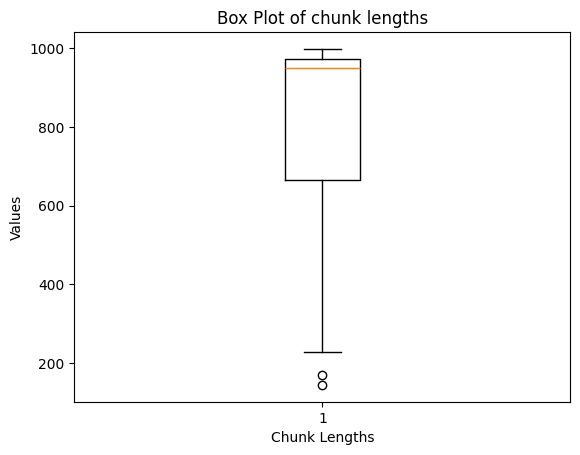

The median chunk lenght is : 949.0
The average chunk lenght is : 815.32
The minimum chunk lenght is : 144
The max chunk lenght is : 998
The 75th percentile chunk length is : 973.0
The 25th percentile chunk length is : 666.0


In [6]:
data = [len(doc.page_content) for doc in pdf_doc_chunks]

plt.boxplot(data)  
plt.title('Box Plot of chunk lengths')  # Title 
plt.xlabel('Chunk Lengths')  # Label for x-axis
plt.ylabel('Values')  # Label for y-axis

plt.show()

print(f"The median chunk lenght is : {round(np.median(data),2)}")
print(f"The average chunk lenght is : {round(np.mean(data),2)}")
print(f"The minimum chunk lenght is : {round(np.min(data),2)}")
print(f"The max chunk lenght is : {round(np.max(data),2)}")
print(f"The 75th percentile chunk length is : {round(np.percentile(data, 75),2)}")
print(f"The 25th percentile chunk length is : {round(np.percentile(data, 25),2)}")

### <span style="color:#47c7fc">Data Transformation or Embeddings</span>

#### __OpenAI Embeddings__

OpenAI, the company behind ChatGPT and GPT series of Large Language Models also provide three Embeddings Models. 

1.	text-embedding-ada-002 was released in December 2022. It has a dimension of 1536 meaning that it converts text into a vector of 1536 dimensions.
2.	text-embedding-3-small is the latest small embedding model of 1536 dimensions released in January 2024. The flexibility it provides over ada-002 model is that users can adjust the size of the dimensions according to their needs.
3.	text-embedding-3-large is a large embedding model of 3072 dimensions released together with the text-embedding-3-small model. It is the best performing model released by OpenAI yet.


OpenAI models are proprietary and can be accessed using the OpenAI API and are priced based on the number of input tokens for which embeddings are desired. 


Note: You will need an __OpenAI API Key__ which can be obtained from [OpenAI](https://platform.openai.com/api-keys)

To initialize the __OpenAI client__, we need to pass the api key. There are many ways of doing it. 

__[Option 1] Creating a .env file for storing the API key and using it # Recommended__

Install the __dotenv__ library

_The dotenv library is a popular tool used in various programming languages, including Python and Node.js, to manage environment variables in development and deployment environments. It allows developers to load environment variables from a .env file into their application's environment._

- Create a file named .env in the root directory of their project.
- Inside the .env file, then define environment variables in the format VARIABLE_NAME=value. 

e.g.

OPENAI_API_KEY=YOUR API KEY

In [7]:
from dotenv import load_dotenv
import os

if load_dotenv():
    print("Success: .env file found with some environment variables")
else:
    print("Caution: No environment variables found. Please create .env file in the root directory or add environment variables in the .env file")

Success: .env file found with some environment variables


We can also test if the key is valid or not

In [8]:
api_key=os.environ["OPENAI_API_KEY"]

from openai import OpenAI

client = OpenAI()


if api_key:
    try:
        client.models.list()
        print("OPENAI_API_KEY is set and is valid")
    except openai.APIError as e:
        print(f"OpenAI API returned an API Error: {e}")
        pass
    except openai.APIConnectionError as e:
        print(f"Failed to connect to OpenAI API: {e}")
        pass
    except openai.RateLimitError as e:
        print(f"OpenAI API request exceeded rate limit: {e}")
        pass

else:
    print("Please set you OpenAI API key as an environment variable OPENAI_API_KEY")



OPENAI_API_KEY is set and is valid


Now we will use the __OpenAIEmbeddings__ library from langchain 

In [9]:
# Import OpenAIEmbeddings from the library
from langchain_openai import OpenAIEmbeddings

os.environ["TOKENIZERS_PARALLELISM"]="false"

# Initialize embeddings with consistent variable name
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Generate embeddings for all document chunks
pdf_doc_embeddings = embeddings.embed_documents([chunk.page_content for chunk in pdf_doc_chunks])

print(f"Generated embeddings for {len(pdf_doc_chunks)} chunks")
print(f"Each embedding has {len(pdf_doc_embeddings[0])} dimensions")

Generated embeddings for 87 chunks
Each embedding has 1536 dimensions


In [10]:
print(f"The lenght of the embeddings vector is {len(pdf_doc_embeddings[0])}")
print(f"The embeddings object is an array of {len(pdf_doc_embeddings)} X {len(pdf_doc_embeddings[0])}")

The lenght of the embeddings vector is 1536
The embeddings object is an array of 87 X 1536


### <span style="color:#47c7fc">Vector Storage</span>

In [11]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

storage_file_path="./Memory"
storage_index_name="PDF_index"

index = faiss.IndexFlatIP(len(pdf_doc_embeddings[0]))

vector_store = FAISS(
    embedding_function=embeddings,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

vector_store.add_documents(documents=pdf_doc_chunks)

['f6f474e7-7a1f-4388-afe8-05fd6ea66724',
 'c7833f83-2cbe-4d7f-83ad-3b93882fda5b',
 '196eefd8-05d2-4e1f-854d-254077bd77a5',
 '9a0dacae-17e4-4f3b-bf43-9cd497c56cfb',
 'd7e92c1b-7fdb-4b3b-a18c-915ff576df11',
 '2edf04f3-4c33-4f31-a13c-a93418a1228a',
 '783785b5-ebea-4246-997a-2f32c67fa8b1',
 'e29b587e-570b-4987-8ac6-7a13203e3a45',
 '0196d366-ee33-474e-a9db-046edfaecb27',
 '875275e9-ad19-4957-9755-122158d3f82b',
 '92e8f623-8596-46c2-9106-ee79c51e7f38',
 '42538c06-df9c-409b-a692-09ef567055d0',
 '3e13544b-c26f-4364-a660-5568778caa43',
 'cdd9ed9c-62dc-4893-b9e1-b1ad93665a29',
 '9ff83852-3dac-44b4-9fe4-170ab736917c',
 '8f583b07-5b96-4127-955b-834899cabd25',
 '2735a26c-2ce7-4524-b7aa-ed551221b9cc',
 'ad73d654-7f02-49dc-98a5-7c1e14f34412',
 '4389c225-3d19-4cf9-be14-38ec37d52698',
 '203bf5c2-bb5a-49a1-8150-3871353e271b',
 'a489a72b-2838-43a6-ab20-a7deedc485d0',
 'd366721d-a728-4b96-ac29-268255fe38f5',
 '32cac8ab-37a1-4fed-93de-543938fd8159',
 'b2bbdd40-40f0-4ab2-9725-a7b032b7ee38',
 '0580a38d-7b28-

We can also save the vector store in persistent memory!

In [12]:
vector_store.save_local(folder_path=storage_file_path,index_name=storage_index_name)

## <span style="color:#ff8000">Generation Pipeline</span>

## <span style="color:#ff8000">1. Retrieval</span>

In [21]:
# Load the FAISS vector store with safe deserialization
vector_store = FAISS.load_local(folder_path="./Memory", index_name="PDF_index", embeddings=embeddings, allow_dangerous_deserialization=True)

# Define a query
query = "Apa saja jenis Layanan Kemahasiswaan yang disediakan ITB?"

# Perform similarity search
retrieved_docs = vector_store.similarity_search(query, k=2)  # Get top 2 relevant chunks

# Display results
for i, doc in enumerate(retrieved_docs):
    print(textwrap.fill(f"\nRetrieved Chunk {i+1}:\n{doc.page_content}",width=100))
    print("\n\n")

 Retrieved Chunk 1: a. Penyaluran Beasiswa dan/atau Bantuan Biaya Pendidikan;  b. Asrarna Mahasiswa;
c. Program Layanan Kesehatan Mahaslswa;  d. Bimbingan clan Konseling;  e. Pelatihan dan Pengembangan
Karakter;  f. Pengembangan Keprofesian dan Kewirausahaan Mahaslswa;  g. Layanan Kegiatan
Kemahasiswaan;  h. Layanan bagi mahasiswa penyanclang disabilitas.  (4) Layanan Kemahasiswaan
sebagairnana dirnaksud pacla ayat (3) clapat  diberikan kepada individu mahasiswa, kelompok
mahasiswa clan/atau  organisasi mahasiswa yang terdaftar atau diakui secara sah oleh ITB.  (5)
Dikecualikan dari ketentuan sebagaimana dimaksud pada ayat (4), bagi  mahasiswa yang sedang
menjalani sanksi atas pelanggaran akademik dari  kemahasiswaan yang ditetapkan oleh 1TB, ticlak
menclapatkan Layanan  Kemahasiswaan sebagaimana dimaksud pada ayat (3).



 Retrieved Chunk 2: 9. Layanan Kesehatan Mahasiswa adalah program bantuan bagi mahasiswa  berupa
pemberian subsidi rawat jalan dan/atau santunan kesehatan.  10. Kegl

This is the most basic implementation of a retriever in the generation pipeline of a RAG-enabled system. This method of retrieval is enabled by embeddings. We used the text-embedding-3-small from OpenAI. FAISS calculated the similarity score based on these embeddings.

---

## <span style="color:#ff8000">2. Augmentation</span>

The information fetched by the retriever should also be sent to the LLM in form of a natural language prompt. This process of combining the user query and the retrieved information is called augmentation.


In [22]:
retrieved_context=retrieved_docs[0].page_content + retrieved_docs[1].page_content

# Creating the prompt
augmented_prompt=f"""

Given the context below answer the question.

Question: {query} 

Context : {retrieved_context}

Remember to answer only based on the context provided and not from any other source. 

If the question cannot be answered based on the provided context, say I don’t know.

"""

print(textwrap.fill(augmented_prompt,width=150))

  Given the context below answer the question.  Question: Apa saja jenis Layanan Kemahasiswaan yang disediakan ITB?   Context : a. Penyaluran Beasiswa
dan/atau Bantuan Biaya Pendidikan;  b. Asrarna Mahasiswa;  c. Program Layanan Kesehatan Mahaslswa;  d. Bimbingan clan Konseling;  e. Pelatihan dan
Pengembangan Karakter;  f. Pengembangan Keprofesian dan Kewirausahaan Mahaslswa;  g. Layanan Kegiatan Kemahasiswaan;  h. Layanan bagi mahasiswa
penyanclang disabilitas.  (4) Layanan Kemahasiswaan sebagairnana dirnaksud pacla ayat (3) clapat  diberikan kepada individu mahasiswa, kelompok
mahasiswa clan/atau  organisasi mahasiswa yang terdaftar atau diakui secara sah oleh ITB.  (5) Dikecualikan dari ketentuan sebagaimana dimaksud pada
ayat (4), bagi  mahasiswa yang sedang menjalani sanksi atas pelanggaran akademik dari  kemahasiswaan yang ditetapkan oleh 1TB, ticlak menclapatkan
Layanan  Kemahasiswaan sebagaimana dimaksud pada ayat (3).9. Layanan Kesehatan Mahasiswa adalah program bantuan bagi m

---

## <span style="color:#ff8000">3. Generation</span>

Generation is the final step of this pipeline. While LLMs may be used in any of the previous steps in the pipeline, the generation step is completely reliant on the LLM. The most popular LLMs are the ones being developed by OpenAI, Anthropic, Meta, Google, Microsoft and Mistral amongst other developers. 

We have built a simple retriever using FAISS and OpenAI embeddings and, we created a simple augmented prompt. Now we will use OpenAI’s model, GPT-4.1-mini, to generate the response.

In [25]:
from langchain_openai import ChatOpenAI


# Set up LLM and embeddings
llm = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

messages=[("human",augmented_prompt)]

ai_msg = llm.invoke(messages)
ai_msg.content

'Jenis Layanan Kemahasiswaan yang disediakan ITB adalah:  \na. Penyaluran Beasiswa dan/atau Bantuan Biaya Pendidikan;  \nb. Asrama Mahasiswa;  \nc. Program Layanan Kesehatan Mahasiswa;  \nd. Bimbingan dan Konseling;  \ne. Pelatihan dan Pengembangan Karakter;  \nf. Pengembangan Keprofesian dan Kewirausahaan Mahasiswa;  \ng. Layanan Kegiatan Kemahasiswaan;  \nh. Layanan bagi mahasiswa penyandang disabilitas.'

## <span style="color:#ff8000">Congratulations!</span>
For completing this introduction to RAG. I hope you had fun. For any queries, please get in touch!

## <span style="color:#ff8000">Testing the Complete RAG Pipeline</span>

Let's test the complete pipeline from indexing to generation with a comprehensive example.

In [ ]:
# Complete RAG Pipeline Test
def test_rag_pipeline():
    print("🔄 Testing Complete RAG Pipeline...")
    print("=" * 50)
    
    # 1. Test data loading
    print("1. Loading PDFs from Assets/Data...")
    pdf_loader = DirectoryLoader(
        './Assets/Data', 
        glob="*.pdf",
        loader_cls=PyPDFLoader,
        use_multithreading=True
    )
    pdf_data = pdf_loader.load()
    print(f"✅ Loaded {len(pdf_data)} pages from PDF files")
    
    # 2. Test chunking
    print("\n2. Chunking documents...")
    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n","\n","."],
        chunk_size=1000,
        chunk_overlap=100,
    )
    pdf_doc_chunks = text_splitter.split_documents(pdf_data)
    print(f"✅ Created {len(pdf_doc_chunks)} chunks")
    
    # 3. Test embeddings
    print("\n3. Creating embeddings...")
    embeddings = OpenAIEmbeddings(model="text-embedding-3-small")
    print("✅ Embeddings model initialized")
    
    # 4. Test vector store creation
    print("\n4. Creating vector store...")
    import faiss
    from langchain_community.docstore.in_memory import InMemoryDocstore
    from langchain_community.vectorstores import FAISS
    
    index = faiss.IndexFlatIP(1536)  # dimension for text-embedding-3-small
    vector_store = FAISS(
        embedding_function=embeddings,
        index=index,
        docstore=InMemoryDocstore(),
        index_to_docstore_id={},
    )
    vector_store.add_documents(documents=pdf_doc_chunks)
    print("✅ Vector store created and populated")
    
    # 5. Save vector store
    print("\n5. Saving vector store...")
    vector_store.save_local(folder_path="./Memory", index_name="PDF_index")
    print("✅ Vector store saved to ./Memory/PDF_index")
    
    # 6. Test retrieval
    print("\n6. Testing retrieval...")
    test_query = "Apa saja peraturan tentang cuti mahasiswa?"
    retrieved_docs = vector_store.similarity_search(test_query, k=3)
    print(f"✅ Retrieved {len(retrieved_docs)} relevant documents")
    
    # 7. Test generation
    print("\n7. Testing generation...")
    from langchain_openai import ChatOpenAI
    
    llm = ChatOpenAI(model="gpt-4.1-mini", temperature=0)
    
    # Create augmented prompt
    context = "\n\n".join([doc.page_content for doc in retrieved_docs])
    augmented_prompt = f"""
    Berdasarkan konteks berikut, jawab pertanyaan dengan bahasa Indonesia.
    
    Pertanyaan: {test_query}
    
    Konteks: {context}
    
    Jawab hanya berdasarkan konteks yang diberikan. Jika tidak bisa dijawab berdasarkan konteks, katakan "Saya tidak tahu berdasarkan dokumen yang tersedia."
    """
    
    messages = [("human", augmented_prompt)]
    response = llm.invoke(messages)
    print("✅ Generated response from LLM")
    
    print("\n" + "=" * 50)
    print("🎉 RAG Pipeline Test Complete!")
    print("=" * 50)
    
    print(f"\n📊 Pipeline Statistics:")
    print(f"• Total pages loaded: {len(pdf_data)}")
    print(f"• Total chunks created: {len(pdf_doc_chunks)}")
    print(f"• Vector store dimension: 1536")
    print(f"• Test query: '{test_query}'")
    print(f"• Documents retrieved: {len(retrieved_docs)}")
    
    print(f"\n💬 Sample Response:")
    print("-" * 30)
    print(response.content[:500] + "..." if len(response.content) > 500 else response.content)
    
    return {
        'pages_loaded': len(pdf_data),
        'chunks_created': len(pdf_doc_chunks),
        'documents_retrieved': len(retrieved_docs),
        'response': response.content
    }

# Run the test
test_results = test_rag_pipeline()

🔄 Testing Complete RAG Pipeline...
1. Loading PDFs from Assets/Data...
✅ Loaded 30 pages from PDF files

2. Chunking documents...
✅ Created 87 chunks

3. Creating embeddings...
✅ Embeddings model initialized

4. Creating vector store...
✅ Vector store created and populated

5. Saving vector store...
✅ Vector store saved to ./Memory/PDF_index

6. Testing retrieval...
✅ Retrieved 3 relevant documents

7. Testing generation...
✅ Generated response from LLM

🎉 RAG Pipeline Test Complete!

📊 Pipeline Statistics:
• Total pages loaded: 30
• Total chunks created: 87
• Vector store dimension: 1536
• Test query: 'Apa saja peraturan tentang cuti mahasiswa?'
• Documents retrieved: 3

💬 Sample Response:
------------------------------
Saya tidak tahu berdasarkan dokumen yang tersedia.
